# **Time Series Forecasting of stock prices of Reliance (RIL) industries**
We are trying to predict the market prices of RIL stocks using the 9 yrs of historical data from June, 2011 - May, 2020 using various **technical indicators** like **MA** (Moving Average), **EMA** (Exponential Moving Average), **MOM** (Momentum), **MACD** (Moving Average Convergence Divergence), **RSI** (Relative Strength Index) and also using TA-Lib library & machine learning algorithms like Linear Regression, Decision Trees, etc.

# Installing TA-lib for technical analysis
First of all, we're using **TA-lib** library which is used for the technical analysis of the stocks prices. So, follow the following procedure to download the zipped folder and then installing it.
 
**Step 1:** Download the zipped folder from the website using the below command. It returns us the .tar file if you look in your downloads after this step. Or you can directly download that file from the website and unzip it.

  "!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz"

**Step 2:** Then using the below command we are unzipping the file.

  "!tar -xzvf ta-lib-0.4.0-src.tar.gz"

**Step 3:** With this command we have entered into the ta-lib folder.
  
  "%cd ta-lib"

**Step 4:** We are here running the configure file and setting prefix as our user.

  "!./configure --prefix=/usr"

**Step 5:** Below commands are preparing for the installation.

"!make"                                                                                                      
"!make install"

**Step 6:** Finally installing the Ta-Lib library using pip install.

  "!pip install Ta-Lib"


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
!make install
!pip install Ta-Lib

**Importing all the required libraries**

In [61]:
import pandas as pd
import numpy as np
from talib.abstract import *
import plotly.graph_objs as go
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats

#mpl.rcParams['figure.figsize'] = (8,6)
#mpl.rcParams['axes.grid'] = True

# **Reading required data using NSEpy library** 
We have used ***nsepy*** library (NSEpy) for fetching the stock data of different companies. It contains stock quotes, historical data, live indices etc. You can look at the deatils about this library from this site - https://nsepy.xyz/ . 

It is very easy to use & handy and also had some built-in functions to extract the data. You can either use those methods or the CLI command. I've fetched the data from its CLI command and store that data into the .csv file for further analysis. I use this way because of the overhead of calling those functions from the server & its taking some time as well. So, instead of calling them again & again I had just stored all that data into the csv file.



In [62]:
# Reading data of RELIANCE stock prices from the csv files for analysis.
# 'output_ril.csv' file contains the training data.
ril = pd.read_csv('/content/output_ril.csv')

# 'output_ril_test.csv' file contains the testing data.
ril_test = pd.read_csv('/content/output_ril_test.csv')

# Now, look at the data, how it looks like. It contains various columns like 'Prec Close' prices, 'Open' prices, 'High' prices,
# 'Low' prices, 'Close' prices, their volumes, trades etc. All these data are on daily basis.
ril_test.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2019-07-01,RELIANCE,EQ,1253.10,1258.05,1272.65,1246.45,1268.9,1268.85,1263.04,6162080,7.782946e+14,145700,1723543,0.2797
1,2019-07-02,RELIANCE,EQ,1268.85,1273.95,1281.00,1263.30,1279.0,1278.50,1272.92,4638751,5.904739e+14,128065,1426211,0.3075
2,2019-07-03,RELIANCE,EQ,1278.50,1282.90,1286.50,1275.05,1282.0,1282.55,1281.62,4026032,5.159835e+14,144904,1524004,0.3785
3,2019-07-04,RELIANCE,EQ,1282.55,1281.40,1291.00,1280.00,1284.0,1284.00,1285.90,4275148,5.497406e+14,104947,1731027,0.4049
4,2019-07-05,RELIANCE,EQ,1284.00,1285.10,1290.50,1260.00,1262.9,1263.35,1275.14,4995344,6.369748e+14,128927,1898594,0.3801


Now, we're creating functions for the general tasks that we can use for other models also where the model works on different company stocks other than reliance.

In this function **to_datetime()**, we're setting an index of a dataframe as a '**Date**' & converting '**Date**' column into datetime format.

In [63]:
def to_datetime(stock):
  
  stock['Date'] = pd.to_datetime(stock['Date'])
  stock.set_index('Date', inplace=True, drop=False)
  return stock

**SMA - Simple Moving Average**, calculates the n days moving avg. to smoothen the closing price.

Calculating moving average of '**Close**' prices using TA-Lib SMA method.

In [64]:
def moving_avg(stck, num_week):
  
  input = stck[['Open', 'High', 'Low', 'Close']]
  stck['movavg_'+str(num_week)] = SMA(input, timeperiod=num_week, price='Close')   
  
  return stck

**EMA - Exponential Moving Average**, which gives more weightage to the recent prices as compared to **SMA**, which gives equal weightage to all the prices. 

Calculating EMA from TA-Lib library's EMA() function.

In [65]:
def ema(stock, days):
  
  stock['EMA_'+str(days)] = EMA(stock['Close'], timeperiod=days)

**RSI - Relative Strength Index** is a momentum indicator used to determine the overbought or oversold condition.

Calculating RSI from the TA-Lib library's RSI() function.

In [66]:
def rsi(stock, time):
  stock['rsi_'+str(time)] = RSI(stock['Close'], timeperiod=time)

**MACD (Moving Average Convergence Divergence)** - It is another momentum indicator, convergence & divergence of 2 MA’s. **Convergence** occurs when 2 MA’s move towards each other & **divergence** occurs when they both move away from each other.

Calculating the MACD from the TA-Lib library's MACD() function.

In [67]:
def Macd(stock, sigp):
  
  macd, macdsignal, macdhist = MACD(stock['Close'], fastperiod=12, slowperiod=26, signalperiod=sigp)
  stock['macd_'+str(sigp)] = macd
  stock['macdsignal_'+str(sigp)] = macdsignal
  stock['macdhist_'+str(sigp)] = macdhist

**Momentum (MOM)** - When the price changes then that rate is momentum. If the prices change rapidly then momentum is high and if it is slowly then momentum is low.

Calculating MOM from the TA-Lib library's MOM() function.

In [68]:
def mom(stock, time):
  stock['mom_'+str(time)] = MOM(stock['Close'], timeperiod=time)

Now, checking the shape of training and testing dataframe.

In [69]:
print("Train data shape : ", ril.shape)   
print("Test data shape : ", ril_test.shape)   

ril = to_datetime(ril)
ril_test = to_datetime(ril_test)

Train data shape :  (2607, 15)
Test data shape :  (254, 15)


**Plotting the OHLC (Open, High, Low, Close) graph on a daily basis data**

In [70]:
fig = go.Figure([go.Ohlc( x = ril.Date, open = ril.Open, high = ril.High, low = ril.Low, close = ril.Close )])
fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(title = "OHLC GRAPH", xaxis_title = 'Time (2011-2020)', yaxis_title = 'Market Prices of stock')
fig.show()

**Plotting the volumes of training & testing data**

**VOLUME** - It’s the volume of stocks buying & selling (for trading). If 100 shares are traded for buying and 100 for selling then the total no. of shares traded is 100 only and not 200.

In [71]:
mean = ril.Volume.mean()

fig = go.Figure()
fig.add_trace(go.Scatter( x = ril.Date, y = ril.Volume, name = 'Train data Volume') )
fig.add_trace(go.Scatter( x = ril_test.Date, y = ril_test.Volume, name = 'Test data Volume') )
layout = { 'shapes': [{ 'type': 'line', 'x0':str(2010), 'y0':mean, 'x1':str(2021), 'y1':mean, 'line': { 'color':'red', 'width':4 }, }],
           'annotations': [ dict( x=str(2013), y=mean, xref="x", yref="y", text="Mean Value of Volumes" ) ],
           'showlegend': True, 'title':"Volumes of stocks", 'yaxis_title':"Number of stocks traded", 'xaxis_title':"Time (2010-2020)" }

fig['layout'].update(layout)
fig.show()

**Plotting SMA's of different days**

The longer the time period of the MA the greater the lag. The 50-day & 200-day MA are most commonly or widely used indicators by investors & traders as well. The shorter MA's are typically used for short-term trading while the longer-term MA's are used for longer term investing/investors.
In this given plot, we can see that how the SMA's are so smooth than the close price.


In [72]:
# Here, we are calling moving_avg function to calculate averages on different days like 7-day, 50-day, 100-day and 200-day.
moving_avg(ril, 7)
moving_avg(ril, 50)
moving_avg(ril, 100)
moving_avg(ril, 200)

fig = go.Figure()
fig.add_trace(go.Scatter( x = ril.Date, y = ril.movavg_7, name = 'SMA 7') )
fig.add_trace(go.Scatter( x = ril.Date, y = ril.movavg_50, name = 'SMA 50') )
fig.add_trace(go.Scatter( x = ril.Date, y = ril.movavg_100, name = 'SMA 100') )
fig.add_trace(go.Scatter( x = ril.Date, y = ril.movavg_200, name = 'SMA 200') )
fig.add_trace(go.Scatter( x = ril.Date, y = ril.Close, name = 'Close') )

fig.update_layout(title = "Visualization showing difference in different SMA's", xaxis_title = 'Time (2011-2020)',
                  yaxis_title = 'Market Prices of stock')
fig.show()

**Plotting EMA's of different days**

 **EMA** is **preferred** by the **traders** as to determine the **trading bias**. For traders, who trade intra-day and fast-moving markets, EMA is more applicable. Here, we're using EMA-12, 26, 50, 200 to show the differences b/w EMA's and close prices. **EMA-50** & **EMA-200** are used as indicators for **long term trends**. When a stock price crosses its 200-day moving avg., its a technical signal that a reversal has occured.

In [73]:
# Here, we are calling the EMA() function to calculate the EMA's of different days.
ema(ril, 12)
ema(ril, 26)
ema(ril, 50)
ema(ril, 200)

fig = go.Figure()
fig.add_trace(go.Scatter( x = ril.Date, y = ril.EMA_12, name = 'EMA 12') )
fig.add_trace(go.Scatter( x = ril.Date, y = ril.EMA_26, name = 'EMA 26') )
fig.add_trace(go.Scatter( x = ril.Date, y = ril.EMA_50, name = 'EMA 50') )
fig.add_trace(go.Scatter( x = ril.Date, y = ril.EMA_200, name = 'EMA 200') )
fig.add_trace(go.Scatter( x = ril.Date, y = ril.Close, name = 'Close') )

fig.update_layout(title = "Visualization showing different EMA's", xaxis_title = 'Time (2011-2020)', yaxis_title = "Market Prices of stock")
fig.show()

**Plotting of RSI with its over-bought/sold conditions**

**RSI** is a leading momentum indicator which finds the relative strength b/w 0 & 100. If RSI is **above 70**, it means shares are **overbought** and ready for downward direction. If RSI is **below 30**, it means shares are **oversold** & are ready to go upward direction. The most used value for RSI is 14 days. We may use 5, 10, 20, 50 or even 100 whatever suits our situation. **The fewer the days, the more volatile the indicator would be**.

In [74]:
# Here, we are using RSI() function to calculate RSI of 14 days. 
rsi(ril, 14)

fig = go.Figure()
fig.add_trace(go.Scatter( x = ril.Date, y = ril.rsi_14, name = 'RSI 14') )
layout = { 'shapes': [{ 'type': 'line', 'x0':str(2010), 'y0':70, 'x1':str(2021), 'y1':70, 'line': { 'color': 'red', 'width': 4 }, },
                      { 'type': 'line', 'x0':str(2010), 'y0':30, 'x1':str(2021), 'y1':30, 'line': { 'color': 'green', 'width': 4 }, } ],
           'annotations': [ dict( x=str(2015), y=70, xref="x", yref="y", text="Above this line is Overbought" ),
                            dict( x=str(2019), y=30, xref="x", yref="y", text="Below this line is Oversold" ) 
                            ],
           'showlegend': True, 'title':"Visualization showing Relative Strength Index of 14 days" }

fig['layout'].update(layout)
fig.show()

**Plotting of MACD and EMA's** 
* **MACD** is a trend following momentum indicator that shows the relationship b/w 2 EMA's - EMA_12 & EMA_26. 
* A **9-day EMA** of the MACD is the **signal line**.
* Traders may **buy the security when macd crosses above its signal line that means short term EMA is above the long term EMA & sell or short when crosses below the signal line that means short term avg. is below the long term avg.**
* The more distant the macd is above or below its baseline (i.e., 0) indicates distance b/w 2 ema's is growing.
* If **macd line** is **above** the **signal line** then **histogram** is **above** its baseline and if **macd line** is **below** its **signal line** then **histogram** is **below** its **baseline**. 

There's also another momentum indicator which does same as the macd is **PPO - Percentage Price Oscillator**. The only diff. b/w them is that the PPO gives us the % diff. while the macd gives us the absolute diff. That means, PPO-10 means short term avg. is 10% above the long term avg. The PPO's % value allows traders to use the indicator to compare diff. assets in terms of performance & volatility. One can use PPO instead of MACD if interested.

In [75]:
# Here, we are using  MACD() function to calculate MACD of 9-days.
Macd(ril, 9)

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter( x = ril.Date, y = ril.Close, name = 'Close'), row=1, col=1)
fig.add_trace(go.Scatter( x = ril.Date, y = ril.EMA_12, name = 'EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter( x = ril.Date, y = ril.EMA_26, name = 'EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter( x = ril.Date, y = ril.macd_9, name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter( x = ril.Date, y = ril.macdsignal_9, name = 'Signal line'), row=2, col=1)

fig.update_layout(title = "Plot shows MACD and its signal line")
fig.show()

**Plotting of Close prices and its momentum**

Below graph shows us the **momentum** of close prices in the range of 10 days. If the **momentum line** is **above 0** that means there's a **overbought** of stocks and if line crosses **below 0** then there is **oversold** of stocks. Also, **crossing above the 0 line during an uptrend** would be a **buy signal** and **crossing below the 0 line during a downtrend** would be a **sell short signal**. 
If prices make a new high or low that isn't confirmed by the momentum indicator, then the divergence may signal a price reversal. 

In [76]:
# Here, we are using MOM() function to calculate the momentum of 10 days.
mom(ril, 10)

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter( x = ril.Date, y = ril.Close, name = 'Close'), row=1, col=1)
fig.add_trace(go.Scatter( x = ril.Date, y = ril.mom_10, name = 'MOM_10'), row=2, col=1)

fig.update_layout(title = "Plots showing the variation of closing prices and its momentum")
fig.show()

**Plotting of close prices of 9 yrs**

Trying to figure out the pattern in the stock prices by plotting the '**Close**' prices against date. And, here we can see that there is a time over the 9 yrs of time-period where there is a sudden drop in the prices. If we look at it then, it was on Sept 6, 2017 the price is Rs. 1645.40 and it drops to Rs. 818.10 on Sept 7, 2017 because of the issuance of bonus share which is in the 1:1 ratio.

In [77]:
fig = px.line(ril, x = 'Date', y = 'Close', title = 'Close Price over the 2011-2020 period')
fig.update_xaxes(rangeslider_visible = True,
                 rangeselector = dict(buttons = list([dict(count=1, label='1y', step='year', stepmode='backward'),
                                                      dict(count=2, label='2y', step='year', stepmode='backward'),
                                                      dict(count=5, label='5y', step='year', stepmode='backward'),
                                                      dict(step='all')])))
fig.show()

**Auto-Correlation Plot**

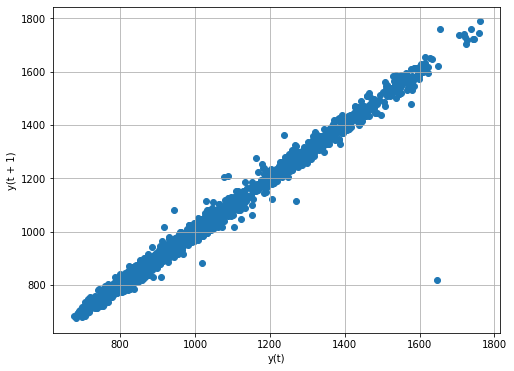

In [78]:
# We should check auto-correlation in the time series that means how the time is correlated with itself. If the time at t and t+1 are
# not correlated then there's a white noise in the data. Also, when we model a time-series the output error or residual will be stationary 
# and will look kind of white noise and then we know that our model is stationary and so time-series.

pd.plotting.lag_plot(ril.Close, lag=1)

**Showing the trend, seasonality and residual or error in stock prices**

<Figure size 576x432 with 0 Axes>

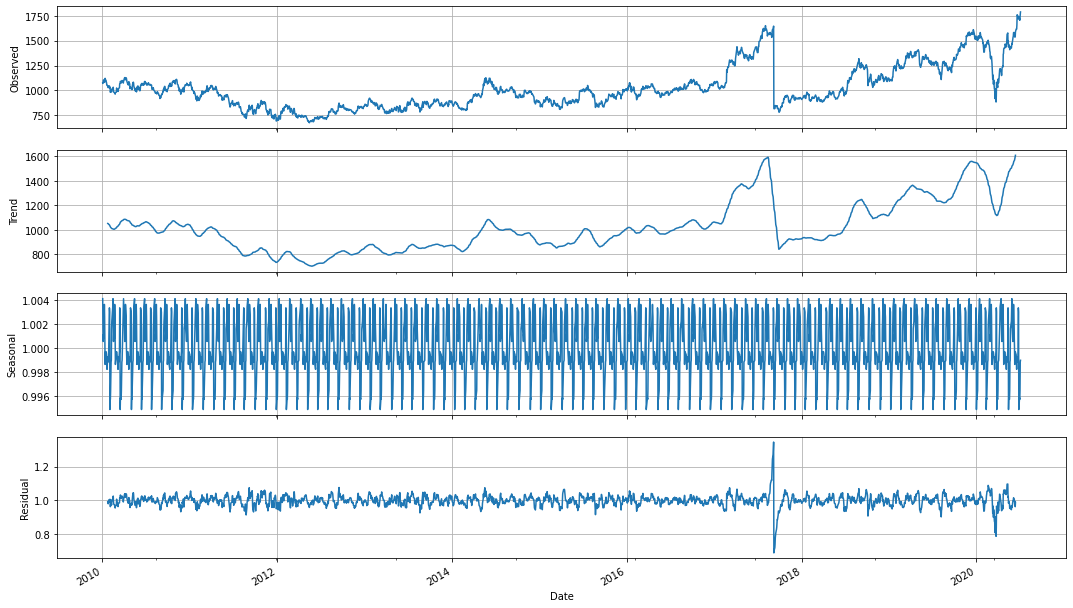

In [79]:
result = seasonal_decompose(ril.Close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Now, we are going to check if there is any null value in the dataset.

In [80]:
ril.info()
ril_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2607 entries, 2010-01-04 to 2020-07-03
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2607 non-null   datetime64[ns]
 1   Symbol              2607 non-null   object        
 2   Series              2607 non-null   object        
 3   Prev Close          2607 non-null   float64       
 4   Open                2607 non-null   float64       
 5   High                2607 non-null   float64       
 6   Low                 2607 non-null   float64       
 7   Last                2607 non-null   float64       
 8   Close               2607 non-null   float64       
 9   VWAP                2607 non-null   float64       
 10  Volume              2607 non-null   int64         
 11  Turnover            2607 non-null   float64       
 12  Trades              2252 non-null   float64       
 13  Deliverable Volume  2607 non-n

Calculating the moving averages of 7, 50, 100 and 200-days on the test data. 

In [81]:
moving_avg(ril_test, 7)
moving_avg(ril_test, 50)
moving_avg(ril_test, 100)
moving_avg(ril_test, 200)


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,movavg_7,movavg_50,movavg_100,movavg_200
Date,,,,,,,,,,,,,,,,,,,
2019-07-01,2019-07-01,RELIANCE,EQ,1253.10,1258.05,1272.65,1246.45,1268.90,1268.85,1263.04,6162080,7.782946e+14,145700,1723543,0.2797,NaN,NaN,NaN,NaN
2019-07-02,2019-07-02,RELIANCE,EQ,1268.85,1273.95,1281.00,1263.30,1279.00,1278.50,1272.92,4638751,5.904739e+14,128065,1426211,0.3075,NaN,NaN,NaN,NaN
2019-07-03,2019-07-03,RELIANCE,EQ,1278.50,1282.90,1286.50,1275.05,1282.00,1282.55,1281.62,4026032,5.159835e+14,144904,1524004,0.3785,NaN,NaN,NaN,NaN
2019-07-04,2019-07-04,RELIANCE,EQ,1282.55,1281.40,1291.00,1280.00,1284.00,1284.00,1285.90,4275148,5.497406e+14,104947,1731027,0.4049,NaN,NaN,NaN,NaN
2019-07-05,2019-07-05,RELIANCE,EQ,1284.00,1285.10,1290.50,1260.00,1262.90,1263.35,1275.14,4995344,6.369748e+14,128927,1898594,0.3801,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-06,2020-07-06,RELIANCE,EQ,1787.90,1805.00,1858.00,1792.10,1855.00,1851.80,1832.66,21698149,3.976530e+15,442095,5644923,0.2602,1758.078571,1561.004,1400.1890,1430.22150
2020-07-07,2020-07-07,RELIANCE,EQ,1851.80,1860.00,1864.35,1806.30,1822.15,1823.45,1831.78,16240102,2.974822e+15,386666,4751023,0.2925,1769.764286,1569.133,1403.8455,1433.21075
2020-07-08,2020-07-08,RELIANCE,EQ,1823.45,1824.05,1834.95,1790.00,1795.40,1798.00,1812.33,12093523,2.191749e+15,285951,4348610,0.3596,1780.457143,1576.498,1407.4890,1436.14700


Calculating EMA, MACD, MOM and RSI as well on the test data with the standard values.

In [82]:
ema(ril_test, 12)
Macd(ril_test, 9)
mom(ril_test, 10)
rsi(ril_test, 14)

**Feature Selection on the basis of their importance on the closing prices**

Now, among all the features 'Prev Close, Open, High, Low, Last' are highly correlated to each other and thus it violates the basis assumption of multi-collinearity. So, considering only few features 'Prev Close, movavg_7, movavg_50, movavg_100, movavg_200, EMA_12, macd_9, mom_10, rsi_14' as our features and 'Close' price as our target variable. Here, we've shifted the 'Close' price to -5 rows because we're going to predict next 5 day closing price.

In [83]:
X_ril = ril[['Prev Close', 'Close', 'movavg_7', 'movavg_50', 'movavg_100', 'movavg_200', 'EMA_12', 'macd_9', 'mom_10', 'rsi_14']]   
y_ril = ril['Close'].shift(-5)

print(X_ril.head())
print(y_ril.head())
print(X_ril.tail())
print(y_ril.tail())

X_ril_test = ril_test[['Prev Close', 'Close', 'movavg_7', 'movavg_50', 'movavg_100', 'movavg_200', 'EMA_12', 'macd_9', 'mom_10', 'rsi_14']] 
y_ril_test = ril_test['Close'].shift(-5)
print(X_ril_test.head())
print(y_ril_test.head())
print(X_ril_test.tail())
print(y_ril_test.tail())

            Prev Close    Close  movavg_7  ...  macd_9  mom_10  rsi_14
Date                                       ...                        
2010-01-04     1090.55  1075.50       NaN  ...     NaN     NaN     NaN
2010-01-05     1075.50  1070.70       NaN  ...     NaN     NaN     NaN
2010-01-06     1070.70  1088.00       NaN  ...     NaN     NaN     NaN
2010-01-07     1088.00  1106.05       NaN  ...     NaN     NaN     NaN
2010-01-08     1106.05  1103.15       NaN  ...     NaN     NaN     NaN

[5 rows x 10 columns]
Date
2010-01-04    1081.50
2010-01-05    1084.35
2010-01-06    1088.60
2010-01-07    1121.70
2010-01-08    1110.75
Name: Close, dtype: float64
            Prev Close    Close     movavg_7  ...     macd_9  mom_10     rsi_14
Date                                          ...                              
2020-06-29     1741.65  1723.15  1733.857143  ...  72.061716  108.60  66.900955
2020-06-30     1723.15  1704.10  1725.957143  ...  68.220753   86.40  63.335644
2020-07-01     17

Removing all the Nan values, starting first 200 values & last 5 from training & testing set.

In [84]:
print("Originally non-null values of train data (X) for reliance:")
X_ril.info()    
X_ril = X_ril[199:-5]
print("\n", "After removing NaN values")
X_ril.info()    
y_ril = y_ril[199:-5]
print("\n", "Shape of target var. after removing NaN values :", y_ril.shape)    

print("\n", "Originally non-null values of test data (X) for reliance:")
X_ril_test.info()
X_ril_test = X_ril_test[199:-5]
print("\n", "After removing NaN values")
X_ril_test.info()
y_ril_test = y_ril_test[199:-5]
print("\n", "Shape of target var. after removing NaN values :", y_ril_test.shape)

Originally non-null values of train data (X) for reliance:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2607 entries, 2010-01-04 to 2020-07-03
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Prev Close  2607 non-null   float64
 1   Close       2607 non-null   float64
 2   movavg_7    2601 non-null   float64
 3   movavg_50   2558 non-null   float64
 4   movavg_100  2508 non-null   float64
 5   movavg_200  2408 non-null   float64
 6   EMA_12      2596 non-null   float64
 7   macd_9      2574 non-null   float64
 8   mom_10      2597 non-null   float64
 9   rsi_14      2593 non-null   float64
dtypes: float64(10)
memory usage: 224.0 KB

 After removing NaN values
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2403 entries, 2010-10-18 to 2020-06-26
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Prev Close  2403 non-null   float64
 1   

Now, all the Nan rows has been removed and it's ready for training and testing. Let's just see how the data looks like.

In [85]:
print("First 5 rows of train data (X) of reliance :")
print(X_ril.head())
print("\n", "First 5 rows of train data (Y) of reliance :")
print(y_ril.head())
print("\n", "Last 5 rows of train data of reliance :")
print(X_ril.tail())
print("\n", "Last 5 rows of train data (Y) of reliance :")
print(y_ril.tail())

print("\n", "First 5 rows of test data (X) of reliance :")
print(X_ril_test.head())
print("\n", "First 5 rows of test data (Y) of reliance :")
print(y_ril_test.head())
print("\n", "Last 5 rows of test data of reliance :")
print(X_ril_test.tail())
print("\n", "Last 5 rows of test data (Y) of reliance :")
print(y_ril_test.tail())

First 5 rows of train data (X) of reliance :
            Prev Close    Close     movavg_7  ...     macd_9  mom_10     rsi_14
Date                                          ...                              
2010-10-18     1040.35  1047.45  1056.328571  ...  16.784477   29.60  56.678032
2010-10-19     1047.45  1044.40  1055.578571  ...  15.666266   20.55  55.657823
2010-10-20     1044.40  1049.45  1052.757143  ...  15.014491    4.50  57.036770
2010-10-21     1049.45  1081.65  1056.478571  ...  16.901396   42.50  64.596781
2010-10-22     1081.65  1081.80  1057.728571  ...  18.199098   32.15  64.628006

[5 rows x 10 columns]

 First 5 rows of train data (Y) of reliance :
Date
2010-10-18    1090.35
2010-10-19    1098.85
2010-10-20    1092.75
2010-10-21    1082.00
2010-10-22    1096.25
Name: Close, dtype: float64

 Last 5 rows of train data of reliance :
            Prev Close    Close     movavg_7  ...     macd_9  mom_10     rsi_14
Date                                          ...           

**Scaling the dataset -**
We're using MinMaxScaler() to scale the training data and testing data because the feature values are on different scale, so to make it on same scale we're doing scaling.

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X_ril, y_ril, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_ril_test)
X_val_scaled = scaler.transform(X_val)

#**Applying Machine Learning Algorithms -**

**Linear Regression Training**

Applying different ML algorithms to check which algo is predicting better. First, trying with the Linear Regression.
From the mean_absolute_error() we can see that there is a difference of 31.82 between predicted and true values which is not a good difference in the case of stock price prediction. But, if we look at the training and validation scores, these are pretty much good giving us 93.37% on train data and 94.62% on validation data. But, on the test data, it seems to have low score and high MAE.

In [87]:
lr = LinearRegression().fit(X_train_scaled, y_train)
y_pred = lr.predict(X_val_scaled)
print("Train score : ", lr.score(X_train_scaled, y_train))
print("Validation score : ", lr.score(X_val_scaled, y_val))
print("mean absolute error : ", mean_absolute_error(y_val, y_pred))

Train score :  0.9337006889856674
Validation score :  0.9462223148022016
mean absolute error :  31.81954023610593


**Linear Regression Testing**

In [88]:
test_lr = lr.predict(X_test_scaled)
print("Test score : ", lr.score(X_test_scaled, y_ril_test))
print("mean absolute error : ", mean_absolute_error(y_ril_test, test_lr))

Test score :  0.6383859929539304
mean absolute error :  67.04331230761083


**Graph showing True values and Predicted values**

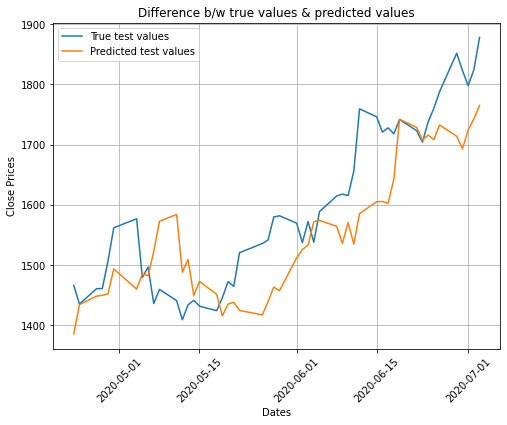

In [89]:
plt.figure(figsize=(8,6))
plt.plot(y_ril_test.index, y_ril_test)
plt.plot(y_ril_test.index, test_lr)
plt.xlabel("Dates")
plt.ylabel("Close Prices")
plt.legend(['True test values', 'Predicted test values'])
plt.title("Difference b/w true values & predicted values")
x = plt.gca().xaxis
for item in x.get_ticklabels():
  item.set_rotation(45)
plt.show()

I have tried to use other versions of Linear Regression like Ridge Regression and Lasso Regression but it seems that both of these has no effect on mean_absolute_error. Therefore, there is a need to apply different type of algorithm to predict the prices so that we can have low mean_absolute_error.

**Use of Decision Tree Regressor for the training of the dataset**

With DecisionTreeRegressor(), we can see that it is giving us high training score of 100% as well as high validation score of 97.29% with MAE of 24.66  which is better than the previous MAE but still not a good number. But, it is comparatively giving us less MAE of 9.82 on test dataset which is quiet good.

In [90]:
dt = DecisionTreeRegressor(criterion='mae', random_state=0).fit(X_train_scaled, y_train)
y_pred = dt.predict(X_val_scaled)
print("Train score : ", dt.score(X_train_scaled, y_train))
print("Validation score : ", dt.score(X_val_scaled, y_val))
print("mean absolute error : ", mean_absolute_error(y_val, y_pred))

Train score :  1.0
Validation score :  0.9729045795750081
mean absolute error :  24.663825363825364


**Use of Decision Tree Regressor for the testing of data**

In [91]:
test_dt = dt.predict(X_test_scaled)
print("Test score : ", dt.score(X_test_scaled, y_ril_test))
print("mean absolute error : ", mean_absolute_error(y_ril_test, test_dt))

Test score :  0.974376173667808
mean absolute error :  9.822999999999997


**Graph showing True values and Predicted values**

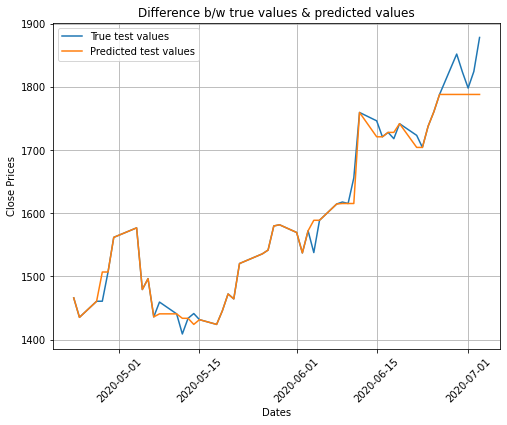

In [92]:
plt.figure(figsize=(8,6))
plt.plot(y_ril_test.index, y_ril_test)
plt.plot(y_ril_test.index, test_dt)
plt.xlabel("Dates")
plt.ylabel("Close Prices")
plt.legend(['True test values', 'Predicted test values'])
plt.title("Difference b/w true values & predicted values")
x = plt.gca().xaxis
for item in x.get_ticklabels():
  item.set_rotation(45)
plt.show()

**Random Forest Regressor Training**

With this algorithm, we can see that it is giving us good scores of 99.65% & 98.78% on both training and validation dataset with a mean absolute error of 18.34 which is better than MAE of Decision Tree regressor. But, on the test dataset we have 89.77% accuracy with MAE of 25.73 which is not good as compared to previous algorithm.

In [93]:
rf = RandomForestRegressor(criterion='mae').fit(X_train_scaled, y_train)
y_pred = rf.predict(X_val_scaled)
print("Train score : ", rf.score(X_train_scaled, y_train))
print("Validation score : ", rf.score(X_val_scaled, y_val))
print("mean absolute error : ", mean_absolute_error(y_val, y_pred))

Train score :  0.9963549162688659
Validation score :  0.9880940224343528
mean absolute error :  18.32999324324315


**Random Forest Regressor Testing**

In [94]:
test_rf = rf.predict(X_test_scaled)
print("Test score : ", rf.score(X_test_scaled, y_ril_test))
print("mean absolute error : ", mean_absolute_error(y_ril_test, test_rf))

Test score :  0.8682132680935524
mean absolute error :  27.791295000000083


**Graph showing True values and Predicted values**

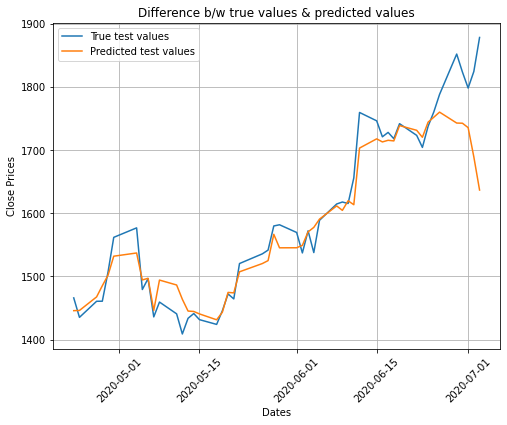

In [95]:
plt.figure(figsize=(8,6))
plt.plot(y_ril_test.index, y_ril_test)
plt.plot(y_ril_test.index, test_rf)
plt.xlabel("Dates")
plt.ylabel("Close Prices")
plt.legend(['True test values', 'Predicted test values'])
plt.title("Difference b/w true values & predicted values")
x = plt.gca().xaxis
for item in x.get_ticklabels():
  item.set_rotation(45)
plt.show()

**Gradient Boosting Regressor Training**

With this algorithm, again we have good scores on both training & validation dataset having 97.58% & 97.66% accuracy with a MAE of 26.89 which is worse than the previous one. Also, on the testing dataset as well it is not giving us good score as it is giving us only 72.37% of accuracy with a MAE of 38.02 , not a god number.

In [96]:
gb = GradientBoostingRegressor(criterion='mae').fit(X_train_scaled, y_train)
y_pred = gb.predict(X_val_scaled)
print("Train score : ", gb.score(X_train_scaled, y_train))
print("Validation score : ", gb.score(X_val_scaled, y_val))
print("mean absolute error : ", mean_absolute_error(y_val, y_pred))

Train score :  0.9759032231976054
Validation score :  0.9760049861767189
mean absolute error :  27.289358405036385


**Gradient Boosting Regressor Testing**

In [97]:
test_gb = gb.predict(X_test_scaled)
print("Test score : ", gb.score(X_test_scaled, y_ril_test))
print("mean absolute error : ", mean_absolute_error(y_ril_test, test_gb))

Test score :  0.8468427616229169
mean absolute error :  31.958958154613633


**Graph showing True values and Predicted values**

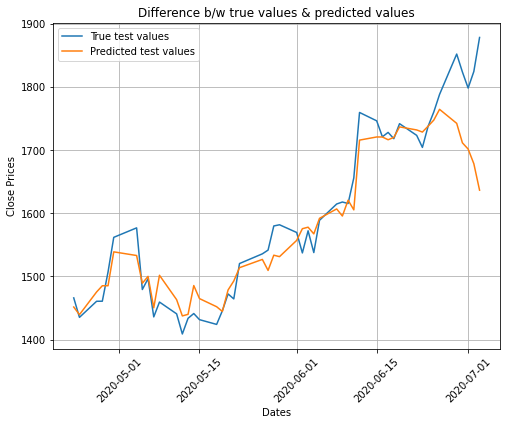

In [98]:
plt.figure(figsize=(8,6))
plt.plot(y_ril_test.index, y_ril_test)
plt.plot(y_ril_test.index, test_gb)
plt.xlabel("Dates")
plt.ylabel("Close Prices")
plt.legend(['True test values', 'Predicted test values'])
plt.title("Difference b/w true values & predicted values")
x = plt.gca().xaxis
for item in x.get_ticklabels():
  item.set_rotation(45)
plt.show()

**XGBoost Regressor Training**

Studies have shown us that this algorithm may work well for the prediction of the prices but wiht this dataset, it is not working good as it has given us MAE of 26.88 with a training accuracy of 98.01% & validation accuracy of 97.69%. On the tes dataset as well, it has not gave us good MAE & good testing score.

In [99]:
model = XGBRegressor().fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print("Train score : ", model.score(X_train_scaled, y_train))
print("Validation score : ", model.score(X_val_scaled, y_val))
print("mean absolute error : ", mean_absolute_error(y_val, y_pred))

[15:04:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train score :  0.9801055649730485
Validation score :  0.9769262538597402
mean absolute error :  26.88297931250812


**XGBoost Regressor Testing**

In [100]:
test_gbr = model.predict(X_test_scaled)
print("Test score : ", model.score(X_test_scaled, y_ril_test))
print("mean absolute error : ", mean_absolute_error(y_ril_test, test_gbr))

Test score :  0.5991311126835788
mean absolute error :  40.06572167968749


**Graph showing True values and Predicted values**

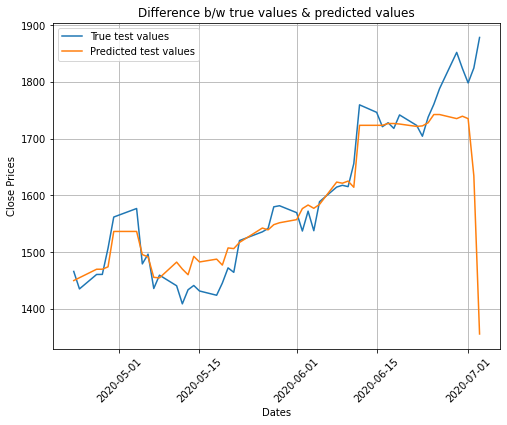

In [101]:
plt.figure(figsize=(8,6))
plt.plot(y_ril_test.index, y_ril_test)
plt.plot(y_ril_test.index, test_gbr)
plt.xlabel("Dates")
plt.ylabel("Close Prices")
plt.legend(['True test values', 'Predicted test values'])
plt.title("Difference b/w true values & predicted values")
x = plt.gca().xaxis
for item in x.get_ticklabels():
  item.set_rotation(45)
plt.show()

At the end, we can say that of all the used algorithms, DecisionTreeRegressor() has worked really well for this dataset. And, giving us good accuracy & good MAE it all depends on a good & cleaned dataset and not on the algorithm. So, it might be possible that some other algorithm can work well on other companies dataset. 

We can also try other algorithms for the best MAE like ARIMA, Prophet, etc. We can also use parameters hypertuning and some optimization techniques so that algorithm will work better. 